In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import DMatrix
from sklearn.metrics import f1_score

from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlp_model import JetParticleDataset_mlp, MLP_Adjustable
from utils import count_parameters, plot_metrics, plot_ROC, calculate_rocs

from time import time
import gc

In [3]:
print('Preparing data...')

        
N = 16         
reverse = ''#'_reversed'
file_path = f'/home/asugu/work/event_data_tt_pad{N}_4mom{reverse}.pkl'

from_checkpoint = False
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_MLP_100.pth'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()


Preparing data...


20

In [4]:


device =  torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  
print(device)

batch_size = 2048
n_epochs = 10
learning_rate = 0.001

in_features = 11
out_features = 1



cuda:1


In [5]:

model = MLP_Adjustable(input_size=(in_features*N), output_size=1, n_hidden_layers = 4, nnodes=256)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

else:
    epoch = 0 
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_train_auc = []
    epoch_train_f1 = []
    epoch_val_loss = []
    epoch_val_accuracy = []
    epoch_val_auc = []
    epoch_val_f1 = []
    scaler_mean = np.array([-0.125])
    scaler_std = np.array([0.59947894])
    scaler=(scaler_mean, scaler_std) 
    #scaler = StandardScaler()
model.to(device)

count_parameters(model)



#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

print("scalr is :", scaler)


+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| hidden_layers.0.weight |   65536    |
|  hidden_layers.0.bias  |    256     |
| hidden_layers.1.weight |   65536    |
|  hidden_layers.1.bias  |    256     |
| hidden_layers.2.weight |   65536    |
|  hidden_layers.2.bias  |    256     |
| hidden_layers.3.weight |   65536    |
|  hidden_layers.3.bias  |    256     |
|     layer1.weight      |   45056    |
|      layer1.bias       |    256     |
|    layerfin.weight     |    256     |
|     layerfin.bias      |     1      |
+------------------------+------------+
Total Trainable Params: 308737
scalr is : (array([-0.125]), array([0.59947894]))


In [6]:
# Create your dataset
dataset = JetParticleDataset_mlp(df, device='cpu', eval=False, transform=None, scaler=scaler, checkpoint=True)

# Get the inputs and labels for training and validation
train_inputs = np.array([dataset.get_inputs(idx) for idx in range(len(dataset))])
train_labels = dataset.get_labels()
train_flavors = dataset.get_flavors()

# Split the data into training and validation sets
#train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, stratify=train_labels, test_size=0.2, shuffle=True, random_state=42)

train_inputs, val_inputs, train_labels, val_labels, train_flavors, val_flavors = train_test_split(
train_inputs, train_labels, train_flavors, stratify=train_labels, test_size=0.2, shuffle=True, random_state=42)

# You can then proceed with the XGBoost data matrices as you initially showed in your code
dtrain = xgb.DMatrix(train_inputs, label=train_labels)
dval = xgb.DMatrix(val_inputs, label=val_labels)

IndexError: invalid index to scalar variable.

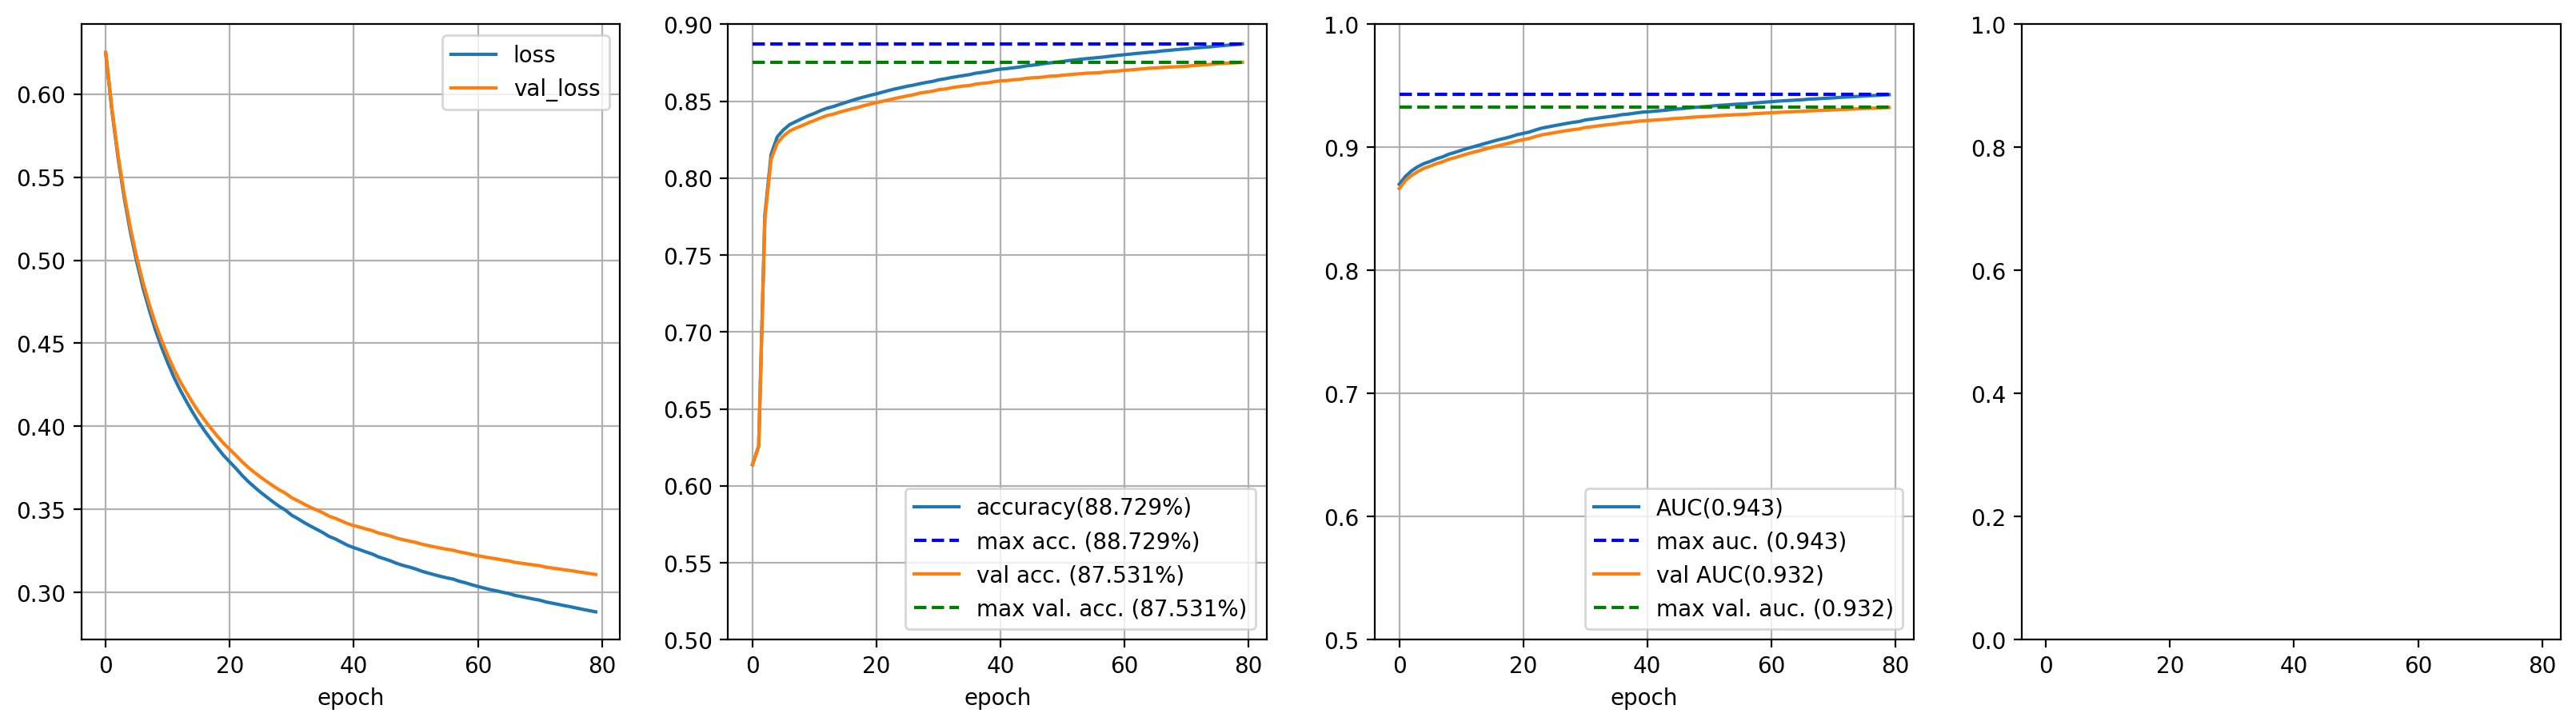

In [7]:

params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc']   
}

num_rounds = 80
eval_results = {} 

model = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'), (dval, 'validation')], evals_result=eval_results)     



# Predict on the training and validation sets
train_probs = model.predict(dtrain)
val_probs = model.predict(dval)


print(train_probs)

#train_probs = model.predict_proba(dtrain)[:, 1]
#val_probs = model.predict_proba(dval)[:, 1]

# Apply threshold of 0.5 to convert to binary labels
threshold = 0.5
train_preds = (train_probs >= threshold).astype(int)
val_preds = (val_probs >= threshold).astype(int)

print(train_preds)
print(train_labels)
# Calculate F1 scores
train_f1 = f1_score(train_labels, train_preds)
val_f1 = f1_score(val_labels, val_preds)


print(f"Train F1 Score: {train_f1}")
print(f"Validation F1 Score: {val_f1}")

train_losses = eval_results['train']['logloss']
val_losses = eval_results['validation']['logloss']
train_errors = eval_results['train']['error']
val_errors = eval_results['validation']['error']
train_aucs = eval_results['train']['auc']
val_aucs = eval_results['validation']['auc']









train_accuracies = [1 - error for error in train_errors]
val_accuracies = [1 - error for error in val_errors]

plot_metrics(np.arange(num_rounds),train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs,train_f1,val_f1)

In [8]:
print(f"Train F1 Score: {train_f1}")
print(f"Validation F1 Score: {val_f1}")

Train F1 Score: 0.8470850563050442
Validation F1 Score: 0.8307915964562004


[0 0 1 ... 0 0 1]
[0 0 1 ... 0 0 1]
[4 0 5 ... 0 4 5]
[0.42505428 0.22991362 0.944226   ... 0.06591156 0.11807065 0.6836602 ]
[0 0 1 ... 0 0 1]


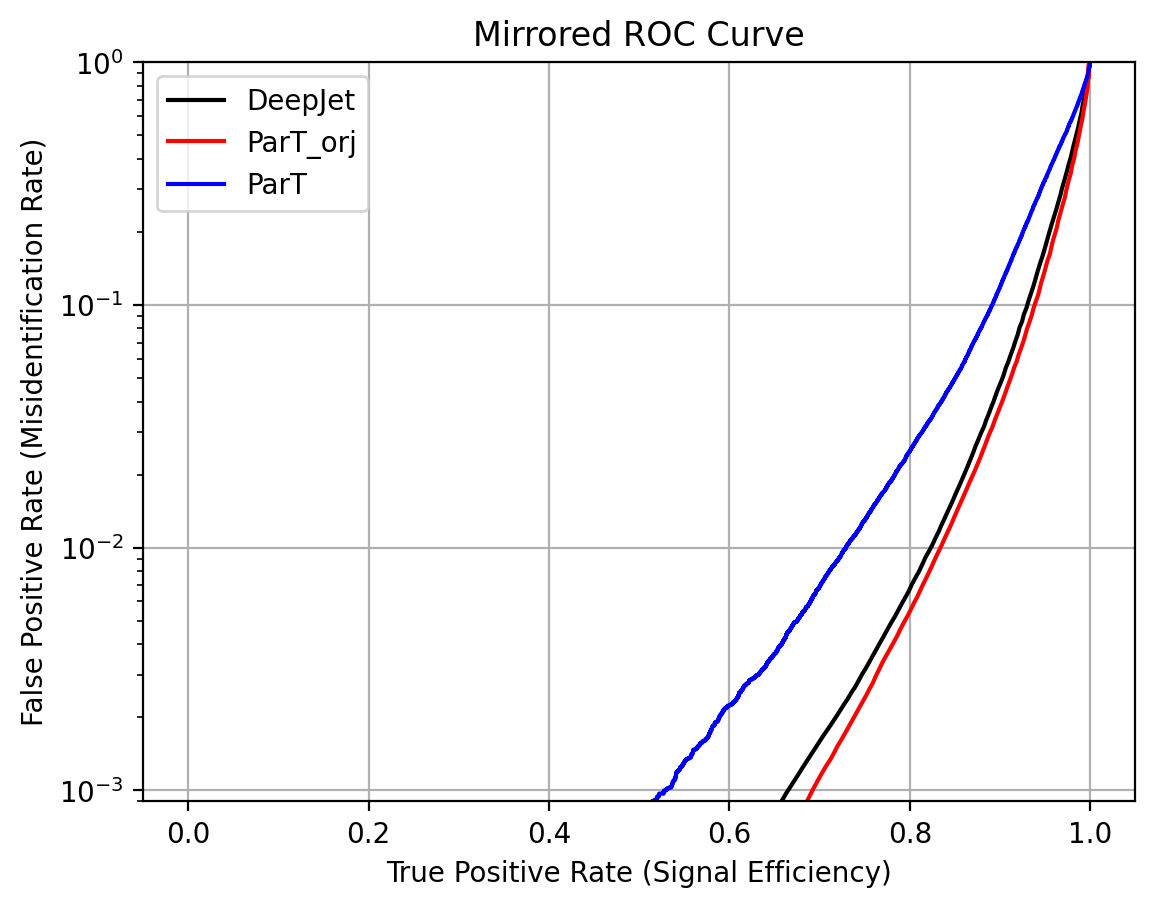

In [15]:
print(val_preds)
print(val_labels)
print(val_flavors)


val_probs = model.predict(dval)
print(val_probs)

val_probs = torch.tensor(val_probs)
val_labels = torch.tensor(val_labels)

l_fpr, l_tpr = calculate_rocs(val_probs, val_labels, val_flavors, remove=False) #c_fpr, c_tpr, 
        
plot_ROC(l_fpr.cpu().numpy(),l_tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_xgb') #c_fpr.cpu().numpy(),c_tpr.cpu().numpy(),


In [17]:
print(l_fpr)
print(l_tpr)

column_names = ['tpr', 'fpr']
pr = pd.DataFrame({'tpr': l_tpr, 'fpr': l_fpr})

# Define the file path for saving
output_path = '/home/asugu/work/benchmark/xgb_bench.csv'

# Save the DataFrame to a CSV file with specified column names
pr.to_csv(output_path, index=False)

tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000])
tensor([0.0000e+00, 9.0064e-06, 1.8013e-05,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])


In [23]:
train_inputs_label_0 = train_inputs[train_labels == 0]
train_labels_label_0 = train_labels[train_labels == 0]

train_inputs_label_1 = train_inputs[train_labels == 1]
train_labels_label_1 = train_labels[train_labels == 1]

# Splitting the validation data into label 0 and label 1 subsets
val_inputs_label_0 = val_inputs[val_labels == 0]
val_labels_label_0 = val_labels[val_labels == 0]

val_inputs_label_1 = val_inputs[val_labels == 1]
val_labels_label_1 = val_labels[val_labels == 1]

print(train_inputs_label_0)
print(train_inputs_label_1)


dtrain_0 = xgb.DMatrix(train_inputs_label_0, label=train_labels_label_0)
dtrain_1 = xgb.DMatrix(train_inputs_label_1, label=train_labels_label_1)
dval_0 = xgb.DMatrix(val_inputs_label_0, label=val_labels_label_0)
dval_1 = xgb.DMatrix(val_inputs_label_1, label=val_labels_label_1)



xgb_train_btag_0 = torch.tensor(model.predict(dtrain_0))
xgb_train_btag_1 = torch.tensor(model.predict(dtrain_1))
xgb_test_btag_0 = torch.tensor(model.predict(dval_0))
xgb_test_btag_1 = torch.tensor(model.predict(dval_1))



[[ 0.00647853  0.00054433  0.01072776 ...  0.          0.
   0.        ]
 [ 0.0218498  -0.01518147 -0.02636499 ...  0.          0.
   0.        ]
 [ 0.02144382 -0.0086236  -0.1690129  ...  0.          0.
   0.        ]
 ...
 [ 0.00628303 -0.01328343 -0.04965835 ...  0.          0.
   0.        ]
 [ 0.00135876  0.01054813 -0.03228435 ...  0.          0.
   0.        ]
 [-0.05219101 -0.03571788 -0.06503707 ...  0.          0.
   0.        ]]
[[ 1.4336176e+00 -1.1617679e-01  7.2421658e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.1897660e-02 -6.5557450e-02 -8.3418712e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.2380346e-02 -2.1516490e-01  8.0889923e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 1.7825618e-02 -2.4415700e-02  1.0044777e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3319032e-01  1.7513204e-01  1.5887550e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.2223896e-03 -6.3191377e-02  1.9321352e-02 ...  0.00

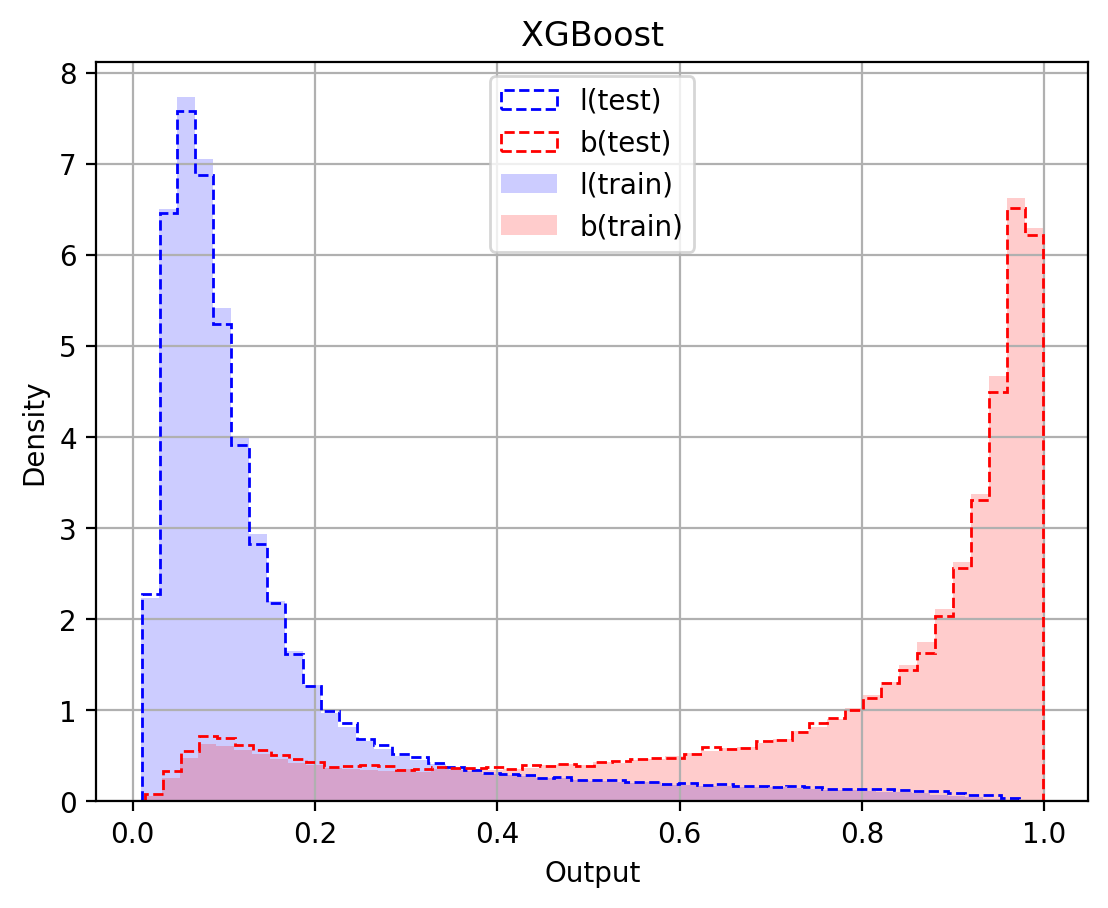

In [24]:
import matplotlib.pyplot as plt

plt.hist(xgb_test_btag_0.cpu().detach().numpy(), bins=50, density=True, label='l(test)', color='blue', histtype='step', linestyle='--')
plt.hist(xgb_test_btag_1.cpu().detach().numpy(), bins=50, density=True, label='b(test)', color='red', histtype='step', linestyle='--')
plt.hist(xgb_train_btag_0.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='l(train)', color='blue')
plt.hist(xgb_train_btag_1.cpu().detach().numpy(), bins=50, density=True, alpha=0.2, label='b(train)', color='red')

plt.xlabel('Output')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.title("XGBoost")

plt.show()